Saving monthly.csv to monthly.csv


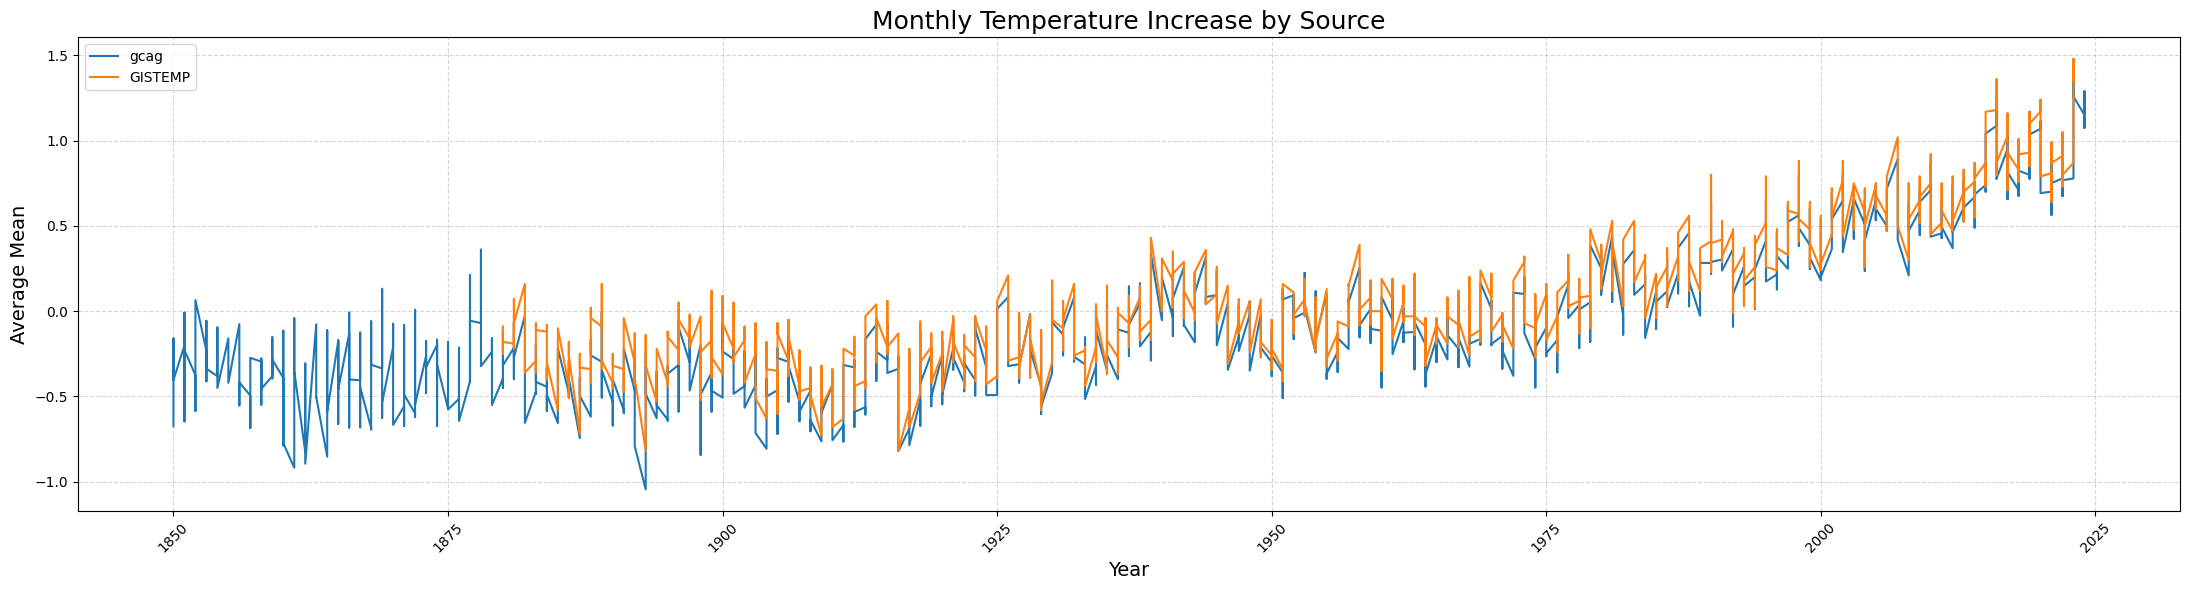

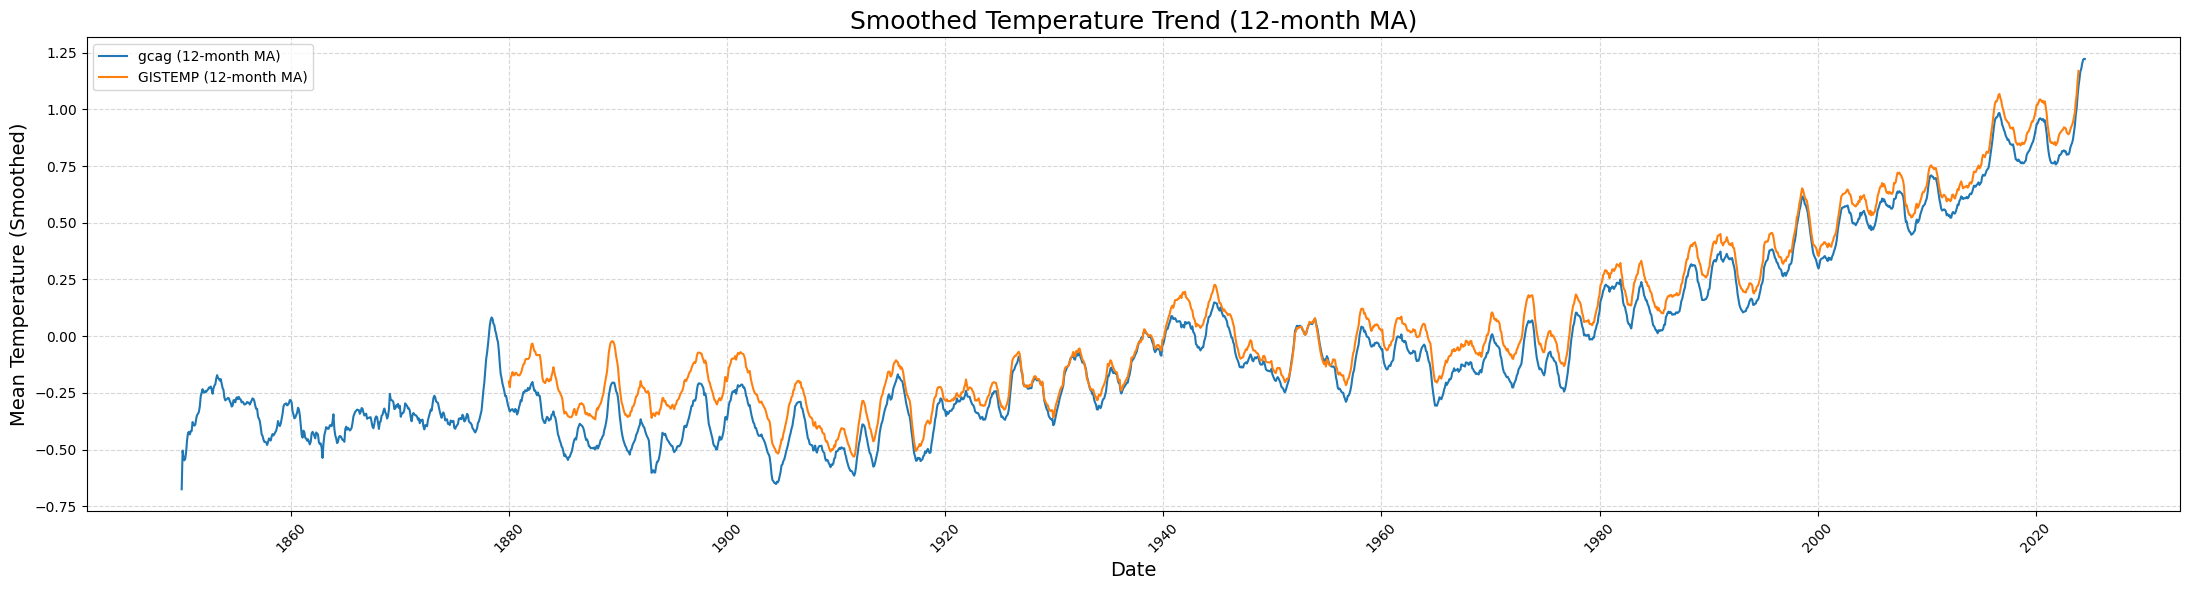

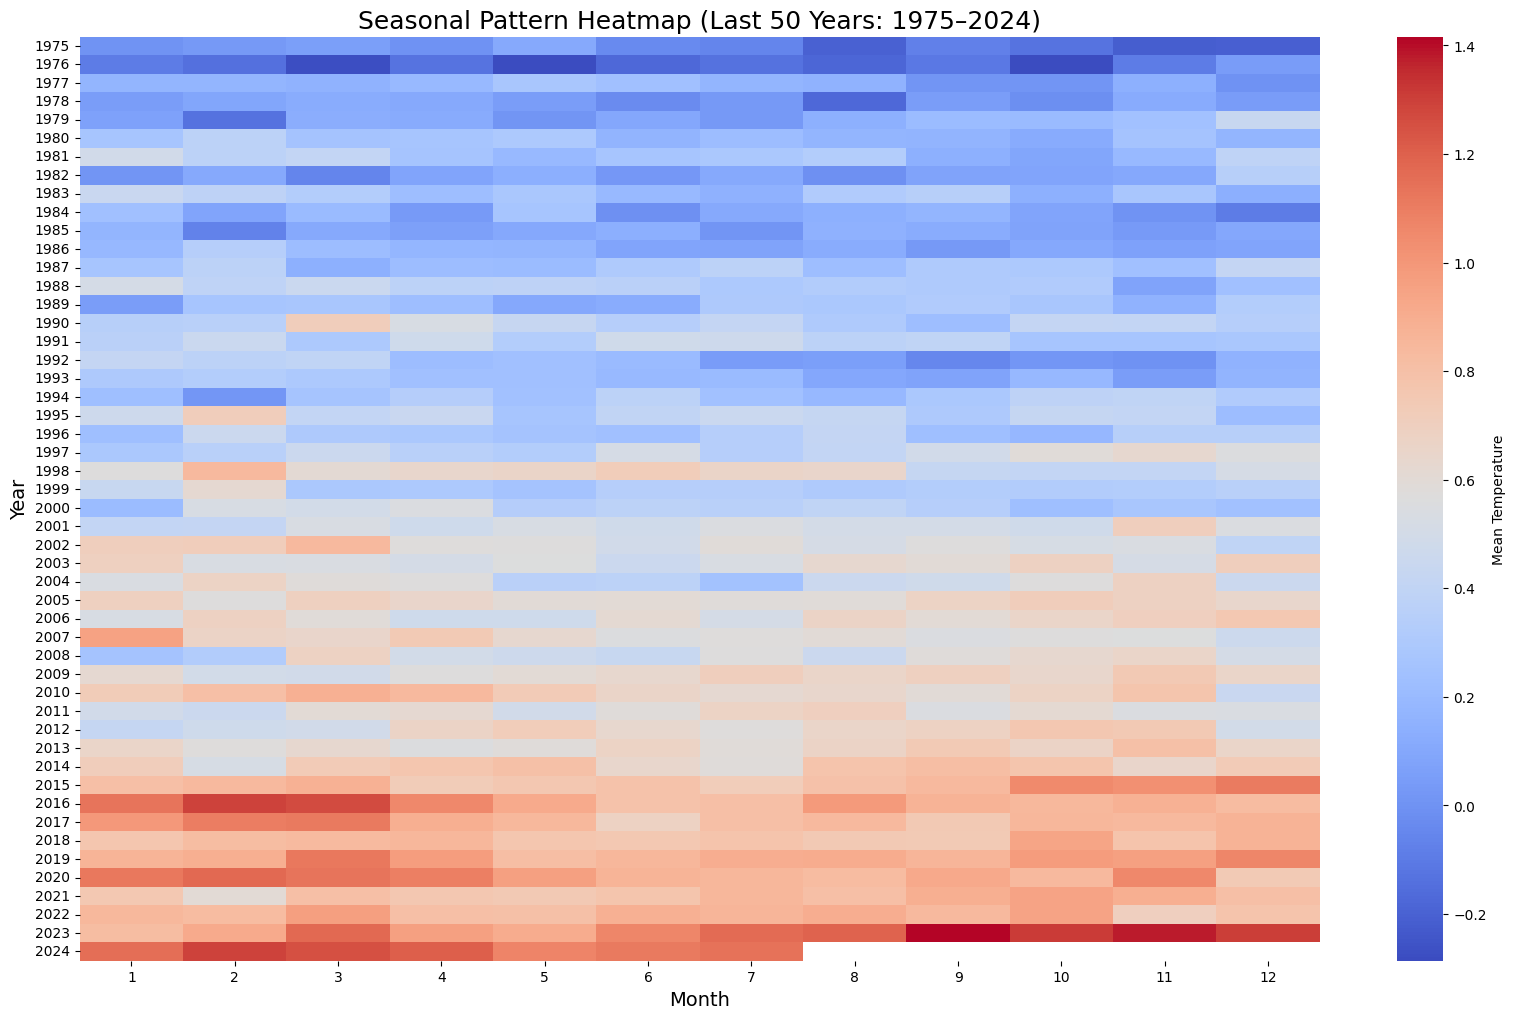

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files  # Only if using Colab

# --- Step 1: Upload CSV ---
uploaded = files.upload()  # Opens file selector
filename = list(uploaded.keys())[0]

# --- Step 2: Load CSV ---
df_temp = pd.read_csv(filename)

# --- Step 3: Clean column names ---
df_temp.columns = df_temp.columns.str.strip()

# Rename temperature column to 'Mean'
df_temp = df_temp.rename(columns={
    'NOAA Land Only Globally averaged Temperature  missing value -999 https://psl.noaa.gov/data/timeseries/month/': 'Mean'
})

# --- Step 4: Convert Year to datetime ---
# Assuming the 'Year' column is in 'YYYY-MM' format
df_temp['Date'] = pd.to_datetime(df_temp['Year'], errors='coerce')
df_temp = df_temp.dropna(subset=['Date'])  # Drop rows with invalid dates

# --- Step 5: Extract Year and Month from the new 'Date' column ---
df_temp['Year'] = df_temp['Date'].dt.year
df_temp['Month'] = df_temp['Date'].dt.month

# --- Step 6: Handle missing temperature values ---
df_temp['Mean'] = pd.to_numeric(df_temp['Mean'], errors='coerce')
df_temp['Mean'] = df_temp['Mean'].replace(-999, pd.NA)
df_temp = df_temp.dropna(subset=['Mean'])

# --- Step 7: Sort by Date ---
df_temp = df_temp.sort_values(by="Date")

# --- Step 8: Calculate 12-month moving average ---
df_temp['Moving_Avg'] = df_temp.groupby('Source')['Mean'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())


# --- Step 9: Plot yearly trend ---
plt.figure(figsize=(22,6))
for source in df_temp['Source'].unique():
    subset = df_temp[df_temp['Source'] == source]
    plt.plot(subset['Year'], subset['Mean'], label=source)

plt.title("Monthly Temperature Increase by Source", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Mean", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Step 10: Plot smoothed moving average ---
plt.figure(figsize=(22,6))
for source in df_temp['Source'].unique():
    subset = df_temp[df_temp['Source'] == source]
    plt.plot(subset['Date'], subset['Moving_Avg'], label=f"{source} (12-month MA)")

plt.title("Smoothed Temperature Trend (12-month MA)", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Mean Temperature (Smoothed)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Step 11: Seasonal heatmap (last 50 years) ---
latest_year = df_temp['Year'].max()
df_last50 = df_temp[df_temp['Year'] >= latest_year - 49]

# Group by Year and Month
seasonal_data = df_last50.groupby(['Year','Month'])['Mean'].mean().reset_index()

# Pivot for heatmap
heatmap_data = seasonal_data.pivot(index='Year', columns='Month', values='Mean')

# Plot heatmap
plt.figure(figsize=(20,12))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, cbar_kws={'label': 'Mean Temperature'})
plt.title(f"Seasonal Pattern Heatmap (Last 50 Years: {latest_year-49}–{latest_year})", fontsize=18)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Year", fontsize=14)
plt.show()